# Q-Learning

We will implement Q-learning for a classic reinforcement learning problem, MountainCar-v0.
We will be using the OpenAI Gym as our environment -- **we strongly recommend looking over the ["Getting Started" documentation](https://gym.openai.com/docs/) .**

From the [official description](https://gym.openai.com/envs/MountainCar-v0/):

> A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.


![](https://user-images.githubusercontent.com/8510097/31701297-3ebf291c-b384-11e7-8289-24f1d392fb48.PNG)


A formal description of the MountainCar task, with action and reward descriptions, can be found [here](https://github.com/openai/gym/wiki/MountainCar-v0):

>The observation space is two dimensional, `[position, velocity]` of type `Box(2)`:
- (horizontal) position: [-1.2, 0.6]
-  velocity: [-0.07, 0.07]

>The goal position is 0.5, the location of the flag on top of the hill.

>There are three possible actions of type `Discrete(3)`:
- 0: push left
- 1: no push
- 2: push right

>Reward: -1 for each time step, until the goal position of 0.5 is reached.

>Initialization: Random position from -0.6 to -0.4 with no velocity.

>Episode ends when you reach 0.5 position, or if 200 timesteps are reached. (So failure to reach the flag will result in a reward of -200).




In [0]:
"""
installing dependencies
"""
!apt-get -qq -y install libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay



In [15]:
"""
Imports
"""

import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
import random
from gym import wrappers

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

import matplotlib.animation
import numpy as np
from IPython.display import HTML

# Note, you may get a few warnings regarding Tensorflow and xdpyinfo, these are to be expected

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [0]:
def discretize(state, discretization, env):
    """
    Helper function for discretizing states. This is required to map the continuous
    observation state space into discrete entries in the Q value matrix.
    
    Args:
        state (Box(2,)): the observation space state, here it is [position, velocity]
        discretization ((np.array): The discretization for each dimension of our observation space
        env: the RL environment 
        
    Returns:
        a discretized (int) version of the observation space state
    """
    env_minimum = env.observation_space.low
    state_adj = (state - env_minimum)*discretization
    discretized_state = np.round(state_adj, 0).astype(int)

    return discretized_state


def choose_action(epsilon, Q, state, env):
    """
    
    Choose an action according to an epsilon greedy strategy.
    
    Args:
        epsilon (float): the probability of choosing a random action
        Q (np.array): The Q value matrix, here it is 3D for the two observation states and action states
        state (Box(2,)): the observation state, here it is [position, velocity]
        env: the RL environment 
        
    Returns:
        action (int): the chosen action
    """
    
    action = 0

    if np.random.random() < 1 - epsilon:
        action = np.argmax(Q[state[0], state[1]]) 
    else:
        action = np.random.randint(0, env.action_space.n)
  
    return action


def update_epsilon(epsilon, decay_rate):
    """
    Decay epsilon by the specified rate.
    
    Args:
        epsilon (float): the probability of choosing a random action
        decay_rate (float): the decay rate (between 0 and 1) to scale epsilon by
        
    Returns:
        updated epsilon
    """
  
    epsilon *= decay_rate

    return epsilon


def update_Q(Q, state_disc, next_state_disc, action, discount, learning_rate, reward, terminal):
    """
    
    Update Q values following the Q-learning update rule. 
    
    Be sure to handle the terminal state case.
    
    Args:
        Q (np.array): The Q value matrix, here it is 3D for the two observation states and action states
        state_disc (np.array): the discretized version of the current observation state [position, velocity]
        next_state_disc (np.array): the discretized version of the next observation state [position, velocity]
        action (int): the chosen action
        discount (float): the discount factor, may be referred to as gamma
        learning_rate (float): the learning rate, may be referred to as alpha
        reward (float): the current (immediate) reward
        terminal (bool): flag for whether the state is terminal
        
    Returns:
        Q, with the [state_disc[0], state_disc[1], action] entry updated.
    """

    
    if terminal:        
        Q[state_disc[0], state_disc[1], action] = reward

    # Adjust Q value for current state
    else:
        delta = learning_rate*(reward + discount*np.max(Q[next_state_disc[0], next_state_disc[1]]) - Q[state_disc[0], state_disc[1],action])
        Q[state_disc[0], state_disc[1],action] += delta
    
    
    return Q

In [17]:
def Qlearning(Q, discretization, env, learning_rate, discount, epsilon, decay_rate, max_episodes):
    """
    
    The main Q-learning function, utilizing the functions implemented above.
  
    Args:
        Q (np.array): The Q value matrix, here it is 3D for the two observation states and action states
        discretization (np.array): The number of discrete states to create for the two observation states 
        env: the RL environment
        learning_rate (float): the learning rate, may be referred to as alpha
        discount (float): the discount factor, may be referred to as gamma
        epsilon (float): the probability of choosing a random action
        decay_rate (float): the amount to decay epsilon
        max_episodes (int): the maximum number of episodes to run
        
    Returns:
        Q (np.array): the final Q value matrix
        ave_reward_list (list): a list of the average reward per 100 episodes
        position_list (list): a list of the final car position states reached over the episodes
        success_list (list): a list of the ratio of successes achieved over the episodes
        frames (list): a list of video frames to render
        
    """
    reward_list = []
    ave_reward_list = []
    position_list = []
    success_list = []
    frames = []
    success = 0 # count of number of successes reached 

    for i in range(max_episodes):
        # Initialize parameters
        done = False # indicates whether the episode is done
        terminal = False # indicates whether the episode is done AND the car has reached the flag (>=0.5 position)
        tot_reward = 0 # sum of total reward over a single
        state = env.reset() # initial environment state
        state_disc = discretize(state,discretization,env)
        
        while done != True:   
            # Render environment for first and last episode. You can change this to render different episodes
            if i == (max_episodes - 1) or i==1:
                frames.append(env.render(mode = 'rgb_array'))
                
            # Determine next action 
            action = choose_action(epsilon, Q, state_disc, env)
            
            # Get next_state, reward, and done using env.step(), see http://gym.openai.com/docs/#environments for reference
            next_state, reward, done, _ = env.step(action) 
            # Discretize next state 
            next_state_disc = discretize(next_state,discretization,env)
            # Update terminal
            terminal = done and next_state[0]>=0.5
            # Update Q
            Q = update_Q(Q,state_disc,next_state_disc,action,discount,learning_rate, reward, terminal)  
            # Update tot_reward, state_disc, and success (if applicable)
            tot_reward += reward
            state_disc = next_state_disc
            if terminal: success +=1 
            
        epsilon = update_epsilon(epsilon, decay_rate) #Update level of epsilon using update_epsilon()
       
        # Track rewards
        reward_list.append(tot_reward)
        position_list.append(next_state[0])
        success_list.append(success/(i+1))

        if (i+1) % 100 == 0:
            ave_reward_list.append(np.mean(reward_list))
            print('Episode: ', i+1, 'Average Reward over 100 Episodes: ',np.mean(reward_list))
            reward_list = []
                
    env.close()
    
    return Q, ave_reward_list, position_list, success_list, frames 


ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [21]:
# Initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.seed(42)
np.random.seed(42)
env.reset()

# Parameters    
learning_rate = 0.2 
discount = 0.9
epsilon = 0.8 
decay_rate = 0.95
max_episodes = 5000
discretization = np.array([10,100])

#InitQ
num_states = (env.observation_space.high - env.observation_space.low)*discretization

#Size of discretized state space 
num_states = np.round(num_states, 0).astype(int) + 1
    
# Initialize Q table
Q = np.random.uniform(low = -1, 
                      high = 1, 
                      size = (num_states[0], num_states[1], env.action_space.n))

# Run Q Learning by calling your Qlearning() function
Q, rewards, position, successes, frames = Qlearning(Q, discretization, env, learning_rate, discount, epsilon, decay_rate, max_episodes)

Episode:  100 Average Reward over 100 Episodes:  -200.0
Episode:  200 Average Reward over 100 Episodes:  -200.0
Episode:  300 Average Reward over 100 Episodes:  -199.31
Episode:  400 Average Reward over 100 Episodes:  -199.5
Episode:  500 Average Reward over 100 Episodes:  -187.22
Episode:  600 Average Reward over 100 Episodes:  -197.59
Episode:  700 Average Reward over 100 Episodes:  -193.0
Episode:  800 Average Reward over 100 Episodes:  -198.56
Episode:  900 Average Reward over 100 Episodes:  -178.68
Episode:  1000 Average Reward over 100 Episodes:  -179.05
Episode:  1100 Average Reward over 100 Episodes:  -177.91
Episode:  1200 Average Reward over 100 Episodes:  -157.72
Episode:  1300 Average Reward over 100 Episodes:  -185.27
Episode:  1400 Average Reward over 100 Episodes:  -176.04
Episode:  1500 Average Reward over 100 Episodes:  -191.86
Episode:  1600 Average Reward over 100 Episodes:  -184.11
Episode:  1700 Average Reward over 100 Episodes:  -170.33
Episode:  1800 Average Rewa

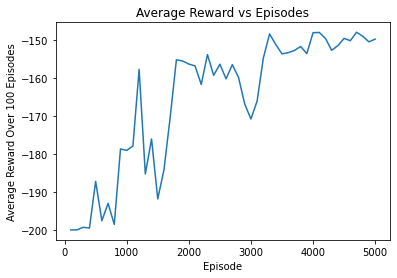

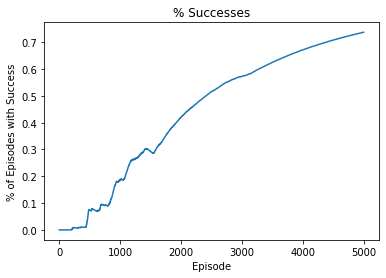

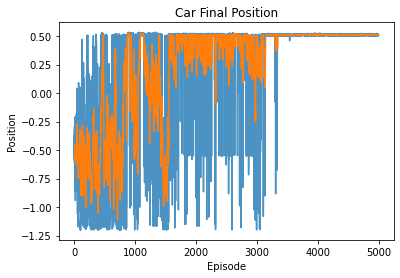

In [22]:
import pandas as pd 

plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward Over 100 Episodes')
plt.title('Average Reward vs Episodes')
plt.show()   
plt.close()  

plt.plot(successes)
plt.xlabel('Episode')
plt.ylabel('% of Episodes with Success')
plt.title('% Successes')
plt.show()
plt.close()

p = pd.Series(position)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.show()

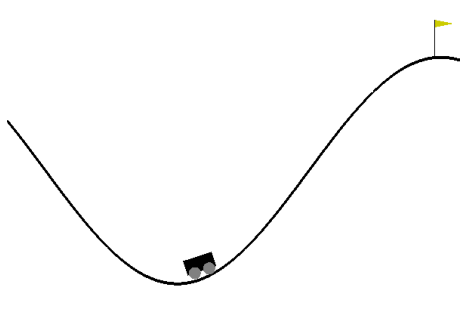

In [23]:
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())